In [1]:
cd ../src

c:\Users\fredl\Documents\Cours\M1 Androide\S2\ML\Projet\src


C:\Users\fredl\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from activation_func import TanH, Sigmoid, ReLU, Softmax, LogSoftmax
from module import Linear, Sequential
from loss import MSELoss, CrossEntropyLoss, BCELoss
from optimizers import Optim
from mltools import *

X = load_usps("../data/USPS_train.txt")
X = X[0]

# A modifier
autoencoder = Sequential(
    Linear(256, 100),
    TanH(),
    Linear(100, 10),
    TanH(),
    Linear(10, 100),
    TanH(),
    Linear(100, 256),
    Sigmoid()
)

loss_fn = BCELoss()

Epoch 0, Loss: 0.7721
Epoch 10, Loss: 0.4536
Epoch 20, Loss: 0.3248
Epoch 30, Loss: 0.2335
Epoch 40, Loss: 0.1479
Epoch 50, Loss: 0.0688
Epoch 60, Loss: -0.0071
Epoch 70, Loss: -0.0662
Epoch 80, Loss: -0.1617
Epoch 90, Loss: -0.2209


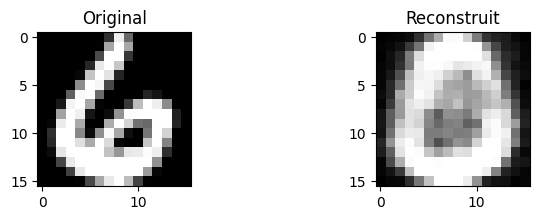

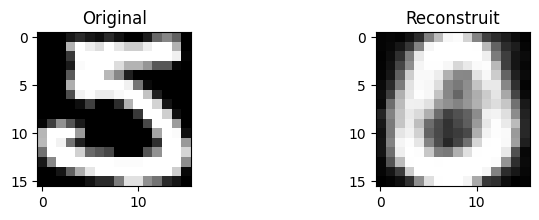

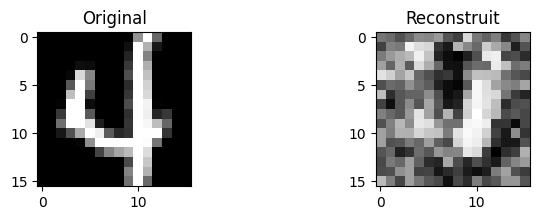

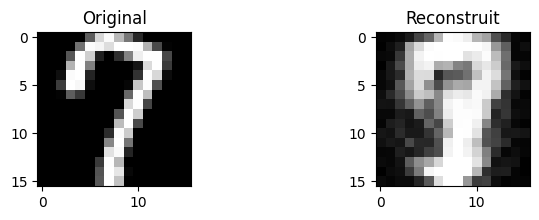

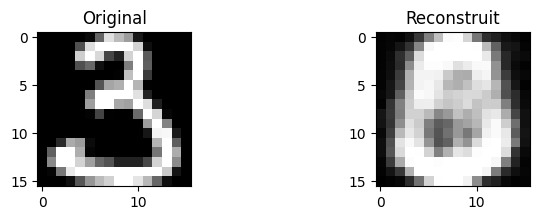

In [14]:
def train_autoencoder(X, model, loss_fn, epochs=100, lr=0.01):
    for epoch in range(epochs):
        total_loss = 0
        model.zero_grad()
        out = model.forward(X)
        loss = loss_fn.forward(X, out)
        delta = loss_fn.backward(X, out)
        model.backward(delta)
        model.update_parameters(lr)
        total_loss += loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

train_autoencoder(X, autoencoder, loss_fn)

X_reconstructed = autoencoder.forward(X)

# Visualisation de quelques reconstructions
for i in range(5):
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(X[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_reconstructed[i].reshape(16, 16), cmap="gray")
    plt.title("Reconstruit")
    plt.show()

KMeans clustering done. Labels: [6 6 7 9 6 3 2 5 1 5]


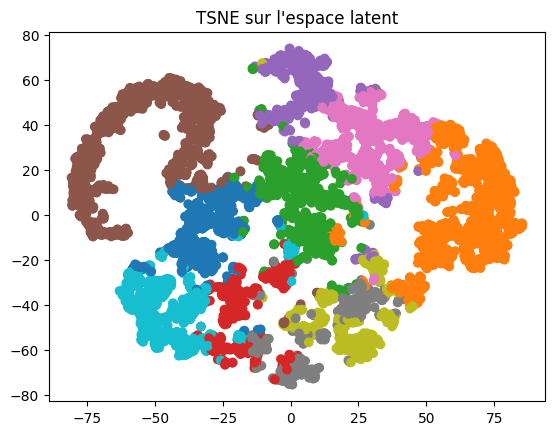

In [15]:
def get_latent_representation(X, model):
    out = X
    for layer in model.modules[:4]:  # jusqu'à Linear(100, 10) + TanH
        out = layer.forward(out)
    return out

latent = get_latent_representation(X, autoencoder)

kmeans = KMeans(n_clusters=10, random_state=0).fit(latent)
labels = kmeans.labels_
print("KMeans clustering done. Labels:", labels[:10])

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title("TSNE sur l'espace latent")
plt.show()

Epoch 0, Loss: 0.7052
Epoch 10, Loss: 0.6278
Epoch 20, Loss: 0.5678
Epoch 30, Loss: 0.5504
Epoch 40, Loss: 0.5411
Epoch 50, Loss: 0.5375
Epoch 60, Loss: 0.5372
Epoch 70, Loss: 0.5297
Epoch 80, Loss: 0.5286
Epoch 90, Loss: 0.5294


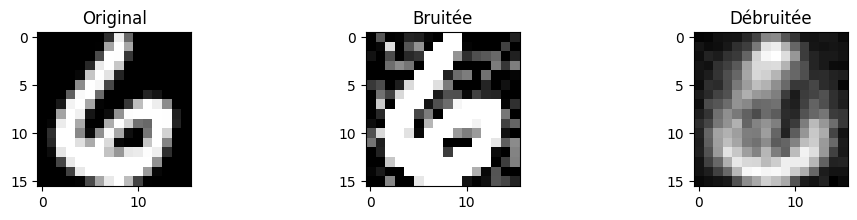

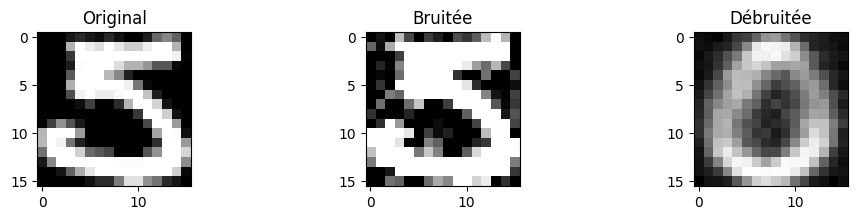

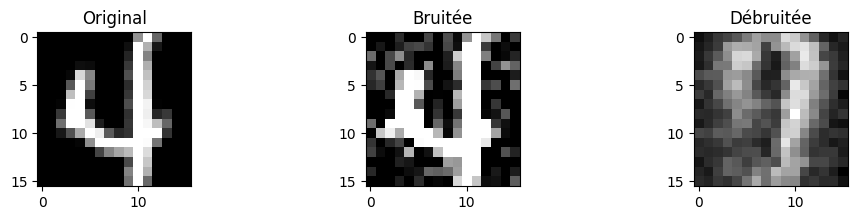

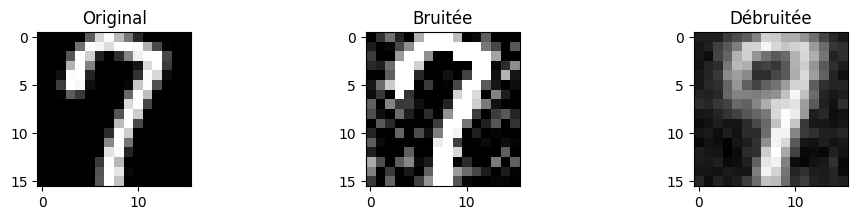

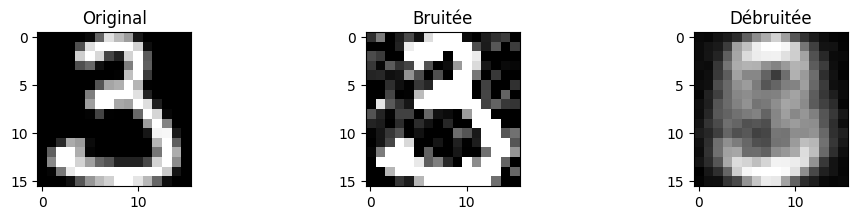

AssertionError: Input dimensions must match weight dimensions

In [ ]:
X_noisy = X + 0.3 * np.random.normal(0, 1, X.shape)
X_noisy = np.clip(X_noisy, 0, 1)

train_autoencoder(X_noisy, autoencoder, loss_fn)
X_denoised = autoencoder.forward(X_noisy)

for i in range(5):
    plt.figure(figsize=(12, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(X[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(X_noisy[i].reshape(16, 16), cmap="gray")
    plt.title("Bruitée")
    plt.subplot(1, 3, 3)
    plt.imshow(X_denoised[i].reshape(16, 16), cmap="gray")
    plt.title("Débruitée")
    plt.show()

# Classification supervisée sur l'espace latent
X_test = load_usps("../data/USPS_test.txt")
X_test = X_test[0]
y_test = X_test[:, -1].astype(int)
X_test = X_test[:, :-1]
X_test = X_test / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train_latent = get_latent_representation(X_train, autoencoder)
X_val_latent = get_latent_representation(X_val, autoencoder)
X_test_latent = get_latent_representation(X_test, autoencoder)

model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train_latent, y_train)
y_pred = model.predict(X_val_latent)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")
y_test_pred = model.predict(X_test_latent)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set: {accuracy_test:.4f}")
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, cmap='tab10')
plt.title("Classification sur l'espace latent")
plt.show()

# Classification supervisée sur l'espace d'entrée
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (input space): {accuracy:.4f}")
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set (input space): {accuracy_test:.4f}")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10')
plt.title("Classification sur l'espace d'entrée")
plt.show()